# Notebook per la gestione dei sensori di temperatura

Per prima cosa collegate la sonda Termometrica DS18B20 al pc tramite il cavo usb. Il sensore offre una rappresentazione a 12 bit della temperatura letta e comunica con Arduino tramite il protocollo 1-Wire. Il codice dello Sketch per Arduino Uno è disponibile nel repository Git della scuola. Per eseguire una cella di codice è sufficiente selezionarla con il mouse e premere CTRL+INVIO.

<a href="https://datasheets.maximintegrated.com/en/ds/DS18B20.pdf"> Qui </a> potete scaricare il datasheet del sensore utilizzato.




In [1]:
import serial
import serial.tools.list_ports
import time

Dopo aver caricato i moduli per la gestione della seriale possiamo enumerare le porte. Se non sono presenti altre schede Arduino, la porta seriale sarà quasi sicuramente /dev/ttyUSB0

In [2]:
com_ports=serial.tools.list_ports.comports()
for p in com_ports:
    print(p.device)

/dev/ttyUSB0


Data la bassa frequenza di aggiornamento della  temperatura, l'interfaccia seriale della scheda Arduino è impostata a 9600bps. L'istruzione seguente apre la porta seriale ed inizia una comunicazione con Arduino a 9600bps, nel caso in cui lo sketch sia stato modificato sarà necessario aggioranre la frequenza di trasmissione dati.

In [3]:
arduino = serial.Serial('/dev/ttyUSB0', baudrate=9600, timeout=1)

Prima di iniziare l'acquisizione dati, controlliamo che la scheda sia attiva e risponda alle nostre sollecitazioni. La funzione Handshake, invia il carattere h ed aspetta una risposta da Arduino. Se la connessione è attiva e funzionante, dovreste ottenere come risposta il carattere R

In [4]:
def handshake_arduino(arduino, sleep_time=1):
    time.sleep(sleep_time);
    timeout = arduino.timeout
    arduino.timeout = 2
    arduino.write('h'.encode())
    while (arduino.in_waiting < 0):
        pass
    response= arduino.read_until()
    print(response.decode().strip())
    arduino.timeout = timeout




handshake_arduino(arduino)

R


La funzione parse_raw_line, legge una linea di input fornita da Arduino, suddivide il testo in due dati, e converte il tempo da millisecondi a secondi

In [5]:
def parse_raw_line(raw_line):
    raw_line = raw_line.decode()
    if raw_line[-1] != "\n":
        raise ValueError(
            "Il messaggio inviato da Arduino deve terminare con il carattere nuova linea."
        )

    time,temp= raw_line.rstrip().split(",");

    return float(time)/1000.,float(temp)

In questa attività le liste che conterranno i valori devono essere passate come parametro alla funzione daq_get_values

In [6]:
def daq_get_values(times,temps,time_base=0):
    # invio il codice per la lettura di una temperatura
    arduino.write('t'.encode())
    
    while arduino.in_waiting < 0:
        pass

    # Leggo i dati inviati tramite seriale a seguito della richiesta di lettura
    raw = arduino.read_until()
      
    # Elaboro i dati forniti, traslando il tempo iniziale 
    try:
        time,temp=parse_raw_line(raw)
        times.append(time-time_base)
        temps.append(temp)
        
    except:
        pass

Controllo il corretto funzionamento del sistema richiedendo la lettura di una temperatura, prima di iniziare una raccolta dati prova sempre a verificare che la temperatura venga letta correttamente

In [7]:
times1 = []
temps1= []

daq_get_values(times1,temps1)
print(times1)
print(temps1)


[14.111]
[21.56]


Carico Matplotlib per la rappresentazione dei dati 

In [8]:
import matplotlib.pyplot as plt 

%matplotlib widget
plt.rcParams['animation.html']='jshtml'


### Funzione per la rappresentazione grafica dei dati


La funzione new_figure deve essere invocata ogni volta in cui viene creata una nuova figura in cui i dati devono essere rappresentanti

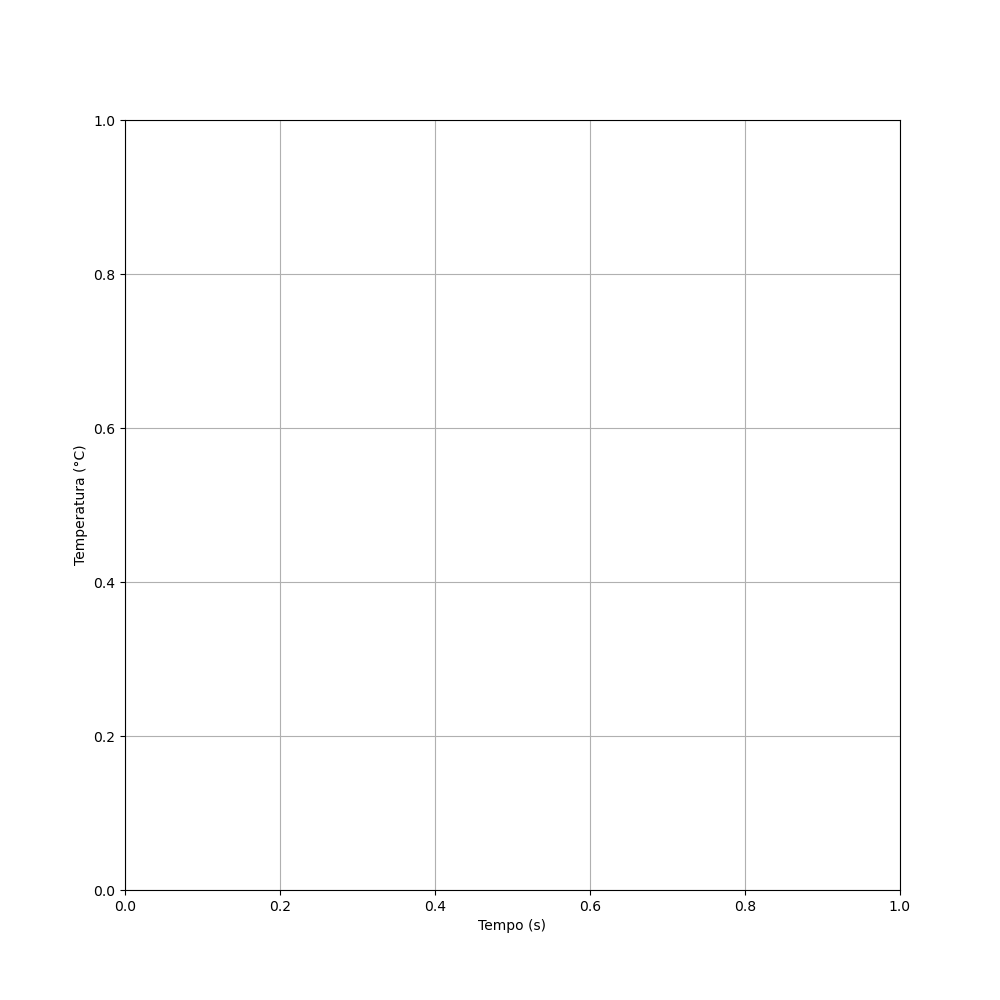

In [19]:
def new_figure():
    fig=plt.figure(figsize=[10,10])
    plt.grid()
    plt.xlabel('Tempo (s)')
    plt.ylabel('Temperatura (°C)')
    #plt.rcParams['figure.dpi'] = 150
    return fig
fig=new_figure()

In [17]:
#La funzione getData raccoglie dati ogni delta_t secondi per un tempo totale pari a run_time
#Ricorda di passare alla funzione la figura in cui vuoi che vengano disegnati i dati

def getData(run_time,delta_t,current_figure):
        
        current_times=[]
        current_temps=[]
        
        arduino.write('n'.encode())
        time.sleep(1);
        arduino.write('r'.encode())
        time.sleep(1);
        #pulisco il buffer seriale
        arduino.read_all()
        daq_get_values(current_times,current_temps)
        run=True
             
        while run:
            
            daq_get_values(current_times,current_temps)
            plt.plot(current_times,current_temps,'-o',color='gray',markerfacecolor='red')
            current_figure.canvas.draw()
            time.sleep(delta_t)
            if current_times[-1]-current_times[0]>run_time:
                run=False
        return current_times,current_temps



In [20]:
test_times,test_temps=getData(50,1,fig)

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np

[[0.03143247023532223, 30.470061886256723],
 [-0.10509773191757334, 34.07625433609534]]

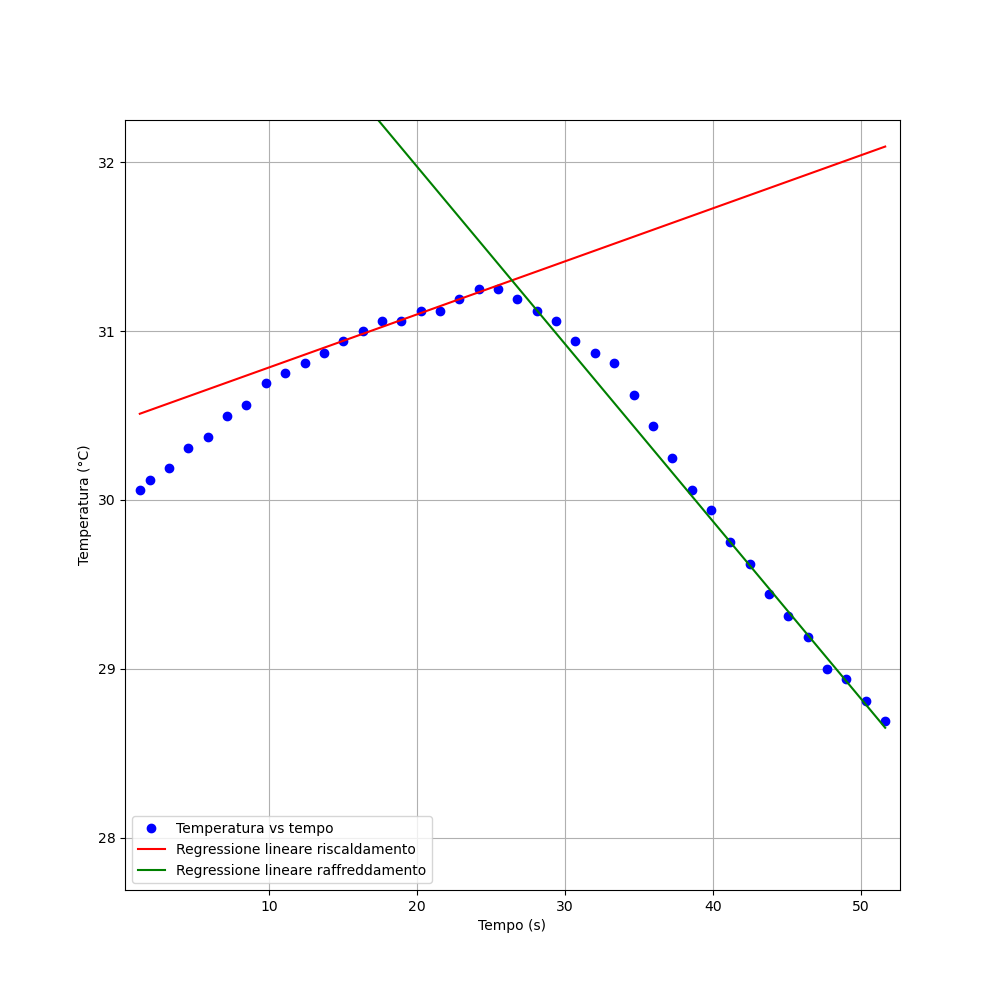

In [22]:
def get_reg_coeff(time_data,temp_data,interval1,interval2):

    #create  slice objects
    regd1=slice(interval1[0],interval1[1])
    regd2=slice(interval2[0],interval2[1])

    #create matplotlib figure
    regfigure,regax= plt.subplots(figsize=[10,10])
    regscatter, = regax.plot([], [], 'bo', label='Temperatura vs tempo')
    plt.grid()
    plt.xlabel('Tempo (s)')
    plt.ylabel('Temperatura (°C)')

    #setup reg lines and plot intervals
    regline1, = regax.plot([], [], 'r', label='Regressione lineare riscaldamento')
    regline2, = regax.plot([], [], 'g', label='Regressione lineare raffreddamento')
    regax.set_xlim(min(time_data)-1, max(time_data)+1)
    regax.set_ylim(min(temp_data)-1,max(temp_data)+1)
    regax.legend()


    #do the linear reg
    reg1 = LinearRegression()
    reg2 = LinearRegression()
    x_train1 = np.array(time_data[regd1]).reshape(-1, 1)
    y_train1 = np.array(temp_data[regd1]).reshape(-1, 1)
    reg1.fit(x_train1,y_train1)
    x_train2 = np.array(time_data[regd2]).reshape(-1, 1)
    y_train2 = np.array(temp_data[regd2]).reshape(-1, 1)
    reg2.fit(x_train2,y_train2)

    #collect results
    lines_data=[[reg1.coef_[0][0],reg1.intercept_[0]],[reg2.coef_[0][0],reg2.intercept_[0]]]

    #plot data
    regscatter.set_data(time_data,temp_data)
    regline1.set_data(time_data, reg1.predict(np.array([entry for entry in time_data]).reshape(-1, 1)))
    regline2.set_data(time_data, reg2.predict(np.array([entry for entry in time_data]).reshape(-1, 1)))
    return lines_data

get_reg_coeff(test_times,test_temps,[10,20],[30,50])